In [124]:
# Import libraries

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import xticks
from sklearn import preprocessing
import numpy as np

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/pro-data-2020-real-estate-prediction/new_train.csv
/kaggle/input/pro-data-2020-real-estate-prediction/new_test.csv


In [125]:
# path = '/content/drive/MyDrive/Bishkek/'
path = '/kaggle/input/pro-data-2020-real-estate-prediction/'

train = pd.read_csv(path + 'new_train.csv')
test = pd.read_csv(path + 'new_test.csv')

print("Train size:", train.shape)
print("Test size:", test.shape)

# we need to predict Price of estate ('Цена'), 
# so delete NaN values in train data

print('Number of NaN values:', train['Цена'].isnull().sum())
train = train[train['Цена'].notnull()]
print("Train size after removing:", train.shape)

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (1,2,3,5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Train size: (178803, 27)
Test size: (9935, 26)
Number of NaN values: 65
Train size after removing: (178738, 27)


Train >25000 (4219, 27)
Train >50000 (1133, 27)
Train >100000 (262, 27)


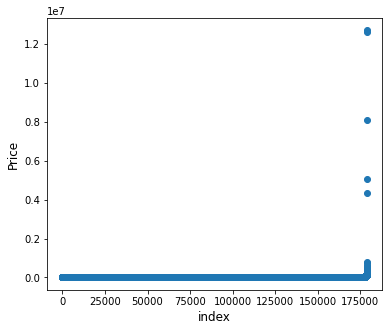

In [126]:
print('Train >25000', train[train['Цена']>25000].shape)
print('Train >50000', train[train['Цена']>50000].shape)
print('Train >100000', train[train['Цена']>100000].shape)
plt.figure(figsize=(6,5))
plt.scatter(range(train.shape[0]), np.sort(train['Цена'].values))
plt.xlabel('index', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.show()

We can see that data > 25000 is less, so take data with Price <25000


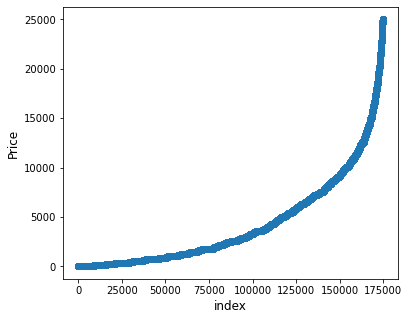

In [127]:
print('We can see that data > 25000 is less, so take data with Price <25000')
train = train[train['Цена']<25000]
plt.figure(figsize=(6,5))
plt.scatter(range(train.shape[0]), np.sort(train['Цена'].values))
plt.xlabel('index', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.show()

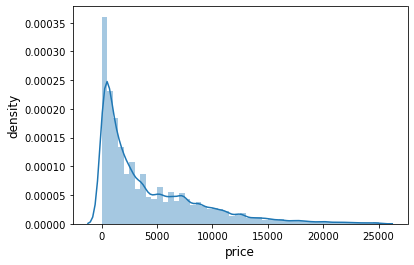

In [128]:
plt.figure(figsize=(6,4))
sns.distplot(train['Цена'].values, bins=50, kde=True)
plt.xlabel('price', fontsize=12)
plt.ylabel('density', fontsize=12)
plt.show()

# **Number of missing values**

**There are vast number of missing values, lets fill rows**

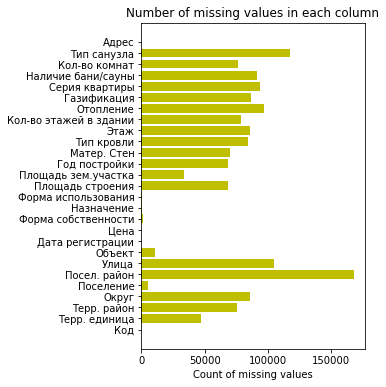

In [129]:
def plot_miss_data(X):
    missing_df = X.isnull().sum(axis=0).reset_index()
    missing_df.columns = ['column_name', 'missing_count']
    missing_df = missing_df[missing_df['missing_count']>=0]
    ind = np.arange(missing_df.shape[0])
    width = 0.8
    fig, ax = plt.subplots(figsize=(4,6))
    rects = ax.barh(ind, missing_df.missing_count.values, color='y')
    ax.set_yticks(ind)
    ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
    ax.set_xlabel("Count of missing values")
    ax.set_title("Number of missing values in each column")
    plt.show()
plot_miss_data(train)

# Fill NaN values

In [130]:
X = train.copy()
Y = test.copy()

names = ['Земельный участок', 'Пашня орошаемая', 'Пашня богарная', 
             'Пашня', 'Богарная пашня', 'Многолетние насаждения', 
             'Сенокос', 'Кошара', 'Мног.насаждения', 'Земельная доля',]

def fill_nan(X):
    # These columns have most NaN values and do not have approach for filling
    X = X.drop(['Посел. район', 'Округ', 'Улица',], axis=1)
    
    # Date of registration
    X['DateRegistr'] = X['Дата регистрации'].apply(lambda x: x[:4]+x[5:7])
    X['DateRegistr'] = X['DateRegistr'].astype(int)
    
    # Number of rooms, 
    # if more than 13 or NaN -> equal to median number
    # for some NaN look at form of usage, if it havenot rooms at all, like arable lands -> equal to 0
    X['Кол-во комнат'] = X['Кол-во комнат'].round()
    median_room_number = X['Кол-во комнат'].median()
    
    X.loc[X['Кол-во комнат'] > 13, 'Кол-во комнат'] = median_room_number
    tmp_df = X[X['Кол-во комнат'].isnull()]
        
    for i in names:
        idx = X[X['Форма использования']==i].index
        X.loc[idx, 'Кол-во комнат'] = 0
        
    X.loc[X['Кол-во комнат'].isnull(), 'Кол-во комнат'] = median_room_number
    
    # Processing with code, maybe separate into categories by price
    X[['Code0', 'Code1','Code2', 'Code3', 'Code4', 'Code5', 'Code6']] = X['Код'].str.split('-', expand=True)
    
    # Floor, HouseFloor, 
    # if more than 15(18) or NaN -> equal to median number
    # for some NaN look at form of usage, if it havenot rooms at all, like arable lands -> equal to 0
    X['Этаж'] = X['Этаж'].round()
    X['Кол-во этажей в здании'] = X['Кол-во этажей в здании'].round()
    
    median_floor = X['Этаж'].median()
    median_housefloor = X['Кол-во этажей в здании'].median()
    
    X.loc[X['Этаж']>15, 'Этаж'] = median_floor
    X.loc[X['Кол-во этажей в здании']>18, 'Кол-во этажей в здании'] = median_housefloor

    for i in names:
        idx = X[X['Форма использования']==i].index
        X.loc[idx, 'Этаж'] = 0
        X.loc[idx, 'Кол-во этажей в здании'] = 0
        
    X.loc[X['Этаж'].isnull(), 'Этаж'] = X.loc[X['Этаж'].isnull(), 'Кол-во этажей в здании']
    X.loc[X['Кол-во этажей в здании'].isnull(), 'Кол-во этажей в здании'] = X.loc[X['Кол-во этажей в здании'].isnull(), 'Этаж']
    X.loc[X['Этаж'].isnull(), 'Этаж'] = median_floor
    X.loc[X['Кол-во этажей в здании'].isnull(), 'Кол-во этажей в здании'] = median_housefloor
    X.loc[X['Этаж'] > X['Кол-во этажей в здании'], 'Этаж'] = X.loc[X['Этаж'] > X['Кол-во этажей в здании'], 'Кол-во этажей в здании']
    
    # Year built, for arable lands and other lands give current year
    median_year = X['Год постройки'].median()
    X['Год постройки'] = X['Год постройки'].replace(0, 2020)
    X.loc[X['Год постройки']<1905, 'Год постройки'] = median_year
    X.loc[X['Год постройки']>2020, 'Год постройки'] = 2020

    for i in names:
        idx = X[X['Форма использования']==i].index
        X.loc[idx, 'Год постройки'] = 2020
        
    X.loc[X['Год постройки'].isnull(), 'Год постройки'] = median_year
    
    # Building area (for lands it's equal 0)
    square_median = X['Площадь строения'].median()
    
    for i in names:
        idx = X[X['Форма использования']==i].index
        X.loc[idx, 'Площадь строения'] = 0

    X.loc[X['Площадь строения'].isnull(), 'Площадь строения'] = square_median
    
    # Land area
    land_median = X['Площадь зем.участка'].median()
    land_names = ['Квартира', 'Парковочное место', 'Нежилое помещение', 'Офис', 'Подвал']

    for i in land_names:
        idx = X[X['Форма использования']==i].index
        X.loc[idx, 'Площадь зем.участка'] = 0
    X.loc[X['Площадь зем.участка'].isnull(), 'Площадь зем.участка'] = land_median
    
    # Terr. unit
    X['Терр. единица'] = X['Терр. единица'].fillna('XXXX1')
#     lbl = preprocessing.LabelEncoder()
#     lbl.fit(list(X['Терр. единица'].values)) 
#     X['Терр. единица'] = lbl.transform(list(X['Терр. единица'].values))
    
    # Terr. disctrict
    X['Терр. район'] = X['Терр. район'].fillna('XXXX2')
#     lbl = preprocessing.LabelEncoder()
#     lbl.fit(list(X['Терр. район'].values)) 
#     X['Терр. район'] = lbl.transform(list(X['Терр. район'].values))
    
    # Form of Ownership
    X['Форма собственности'] = X['Форма собственности'].fillna('Другая')
#     lbl = preprocessing.LabelEncoder()
#     lbl.fit(list(train['Форма собственности'].values)) 
#     X['Форма собственности'] = lbl.transform(list(X['Форма собственности'].values))
    
    # Purpose, Walls material, Cover type
    other_names = ['Назначение', 'Матер. Стен', 'Тип кровли', 'Отопление']
    for i in other_names:
        X[i] = X[i].fillna('Другое')
#         lbl = preprocessing.LabelEncoder()
#         lbl.fit(list(train[i].values)) 
#         X[i] = lbl.transform(list(X[i].values))
    
    # Form os Usage
    X['Форма использования'] = X['Форма использования'].fillna('Другое')
    
    # Object type
    X['Объект'] = X['Объект'].fillna('XXXX3')
    
    # Gas
    X['Газификация'] = X['Газификация'].replace(to_replace=['N', 'Y'], value=[0, 1])
    X['Газификация'] = X['Газификация'].fillna(0)
    X['Газификация'] = X['Газификация'].astype(int)
    
    # Bath/Sauna
    X['Наличие бани/сауны'] = X['Наличие бани/сауны'].replace(to_replace=['N', 'Y'], value=[0, 1])
    X['Наличие бани/сауны'] = X['Наличие бани/сауны'].fillna(0)
    X['Наличие бани/сауны'] = X['Наличие бани/сауны'].astype(int)
    
    # Address
    df_X = X['Адрес'].str.split('-', expand=True)
    df_X[1] =df_X[1].fillna('XYXY')
    df_X = df_X[[0,1]]
    df_X = df_X.rename(columns={0:'Address0', 1:'Address1'})
    X = pd.concat([X, df_X], axis=1)
    X = X.drop('Адрес', axis=1)
    
    
    X = X.drop(['Код', 'Code3', 'Code4', 'Code5', 'Code6', 'Дата регистрации', 'Поселение'], axis=1)
    return X

X = fill_nan(X)
Y = fill_nan(Y)

In [131]:
def Encoding(X, Y): # train, test
    lbl = preprocessing.LabelEncoder()
       
    other_names = ['Терр. единица', 'Терр. район', 'Форма собственности', 'Code0', 
                   'Code1', 'Code2', 'Address0',
                   'Назначение', 'Матер. Стен', 'Тип кровли', 'Отопление', ]
    
    for i in other_names:
        lbl.fit(list(X[i].values)) 
        X[i] = lbl.transform(list(X[i].values))
        Y[i] = lbl.transform(list(Y[i].values))
    
    
    return X, Y

X, Y = Encoding(X, Y)

# Categorize by price

Categorize Codes 

In [132]:
group_df = X.groupby('Code0')['Цена'].aggregate(np.median).reset_index().rename(columns={'Цена':'Code0_price'})
X = X.merge(group_df, on=['Code0'], how='left')
Y = Y.merge(group_df, on=['Code0'], how='left')
def Code0_to_cat(X):
    X['Code0_cat'] = np.nan
    X.loc[X['Code0_price'] < 1000, 'Code0_cat'] = 1
    X.loc[(X['Code0_price'] >= 1000) & (X['Code0_price'] <= 2000), 'Code0_cat'] = 2
    X.loc[(X['Code0_price'] > 2000), 'Code0_cat'] = 3
    return X

X, Y = Code0_to_cat(X), Code0_to_cat(Y)

group_df = X.groupby('Code1')['Цена'].aggregate(np.median).reset_index().rename(columns={'Цена':'Code1_price'})
X = X.merge(group_df, on=['Code1'], how='left')
Y = Y.merge(group_df, on=['Code1'], how='left')
def Code1_to_cat(X):
    X['Code1_cat'] = np.nan
    X.loc[X['Code1_price'] < 1500, 'Code1_cat'] = 1
    X.loc[(X['Code1_price'] >= 1500) & (X['Code1_price'] <= 3000), 'Code1_cat'] = 2
    X.loc[(X['Code1_price'] > 3000), 'Code1_cat'] = 3
    return X

X, Y = Code1_to_cat(X), Code1_to_cat(Y)

group_df = X.groupby('Code2')['Цена'].aggregate(np.median).reset_index().rename(columns={'Цена':'Code2_price'})
X = X.merge(group_df, on=['Code2'], how='left')
Y = Y.merge(group_df, on=['Code2'], how='left')
def Code2_to_cat(X):
    X['Code2_cat'] = np.nan
    X.loc[X['Code2_price'] < 1500, 'Code2_cat'] = 1
    X.loc[(X['Code2_price'] >= 1500) & (X['Code2_price'] <= 3000), 'Code2_cat'] = 2
    X.loc[(X['Code2_price'] > 3000), 'Code2_cat'] = 3
    return X

X, Y = Code2_to_cat(X), Code2_to_cat(Y)

Categorize objects

In [133]:
group_df = X.groupby('Объект')['Цена'].aggregate(np.median).reset_index().rename(columns={'Цена':'Object_price'})
X = X.merge(group_df, on=['Объект'], how='left')
Y = Y.merge(group_df, on=['Объект'], how='left')
def Object_to_cat(X):
    X['object_cat'] = np.nan
    X.loc[X['Object_price'] < 1000, 'object_cat'] = 1
    X.loc[(X['Object_price']>= 1000) & (X['Object_price'] <= 2000), 'object_cat'] = 2
    X.loc[(X['Object_price'] > 2000) & (X['Object_price'] <= 4000), 'object_cat'] = 3
    X.loc[(X['Object_price'] > 4000) & (X['Object_price'] <= 6000), 'object_cat'] = 4
    X.loc[(X['Object_price'] > 6000) & (X['Object_price'] <= 8000), 'object_cat'] = 5
    X.loc[(X['Object_price'] > 8000), 'object_cat'] = 6
    return X

X, Y = Object_to_cat(X), Object_to_cat(Y)

Y.loc[Y['Object_price'].isnull(), 'Object_price'] = X['Цена'].median()
Y.loc[Y['object_cat'].isnull(), 'object_cat'] = 3
X, Y = X.drop('Объект', axis=1), Y.drop('Объект', axis=1)

Categorize Form of Usage

In [134]:
# group_df = X.groupby('Форма использования')['Цена'].aggregate(np.median).reset_index().rename(columns={'Цена':'UsageForm_price'})
# plt.figure(figsize=(9,6))
# sns.barplot(group_df['Форма использования'].values, group_df['UsageForm_price'].values, alpha=0.8)
# plt.ylabel('Median Price', fontsize=12)
# plt.xlabel('Form', fontsize=12)
# plt.xticks(rotation='vertical')
# plt.show()

In [135]:
group_df = X.groupby('Форма использования')['Цена'].aggregate(np.median).reset_index().rename(columns={'Цена':'UsageForm_price'})
X = X.merge(group_df, on=['Форма использования'], how='left')
Y = Y.merge(group_df, on=['Форма использования'], how='left')

def UsageForm_to_cat(X):
    X['usageform_cat'] = np.nan
    X.loc[X['UsageForm_price'] < 1000, 'usageform_cat'] = 1
    X.loc[(X['UsageForm_price'] >= 1000) & (X['UsageForm_price'] <= 2000), 'usageform_cat'] = 2
    X.loc[(X['UsageForm_price'] > 2000) & (X['UsageForm_price'] <= 4000), 'usageform_cat'] = 3
    X.loc[(X['UsageForm_price'] > 4000) & (X['UsageForm_price'] <= 6000), 'usageform_cat'] = 4
    X.loc[(X['UsageForm_price'] > 6000) & (X['UsageForm_price'] <= 8000), 'usageform_cat'] = 5
    X.loc[(X['UsageForm_price'] > 8000), 'usageform_cat'] = 6
    return X

X = UsageForm_to_cat(X)
Y = UsageForm_to_cat(Y)
Y.loc[Y['UsageForm_price'].isnull(), 'UsageForm_price'] = X['Цена'].median()
Y.loc[Y['usageform_cat'].isnull(), 'usageform_cat'] = 3
X = X.drop('Форма использования', axis=1)
Y = Y.drop('Форма использования', axis=1)

**Processing Address**

In [136]:
group_df = X.groupby('Address0')['Цена'].aggregate(np.median).reset_index().rename(columns={'Цена':'Address0_price'})
X = X.merge(group_df, on=['Address0'], how='left')
Y = Y.merge(group_df, on=['Address0'], how='left')
def Address0_to_cat(X):
    X['Address0_cat'] = np.nan
    X.loc[X['Address0_price'] < 1000, 'Address0_cat'] = 1
    X.loc[(X['Address0_price'] >= 1000) & (X['Address0_price'] <= 2000), 'Address0_cat'] = 2
    X.loc[(X['Address0_price'] > 2000), 'Address0_cat'] = 3
    return X
X = Address0_to_cat(X)
Y = Address0_to_cat(Y)

X = X.drop(['Address1', 'Тип санузла','Серия квартиры'],  axis=1)
Y = Y.drop(['Address1', 'Тип санузла','Серия квартиры'], axis=1)

Separate district by price

In [137]:
group_df = X.groupby('Терр. район')['Цена'].aggregate(np.median).reset_index().rename(columns={'Цена':'terr_raion_byprice'})
X = X.merge(group_df, on=['Терр. район'], how='left')
Y = Y.merge(group_df, on=['Терр. район'], how='left')
X['terrraoin_cat_price'] = X['terr_raion_byprice'].apply(lambda x: 1 if x < 1000 
                                                            else (2 if 1000<=x<2000 
                                                                  else 3))
Y['terrraoin_cat_price'] = Y['terr_raion_byprice'].apply(lambda x: 1 if x < 1000 
                                                            else (2 if 1000<=x<2000 
                                                                  else 3))

Categorize built year and date of registration by price

In [138]:
group_df = X.groupby('DateRegistr')['Цена'].aggregate(np.median).reset_index().rename(columns={'Цена':'Price_date'})
X = X.merge(group_df, on=['DateRegistr'], how='left')
Y = Y.merge(group_df, on=['DateRegistr'], how='left')
def date_to_cat(X):
    X['Price_date_cat'] = np.nan
    X.loc[X['Price_date'] < 2500, 'Price_date_cat'] = 1
    X.loc[(X['Price_date'] >= 2500) & (X['Price_date'] <= 2700), 'Price_date_cat'] = 2
    X.loc[(X['Price_date'] > 2700), 'Price_date_cat'] = 3        
    return X
def year_to_cat(X):
    X['year_cat'] = np.nan
    X.loc[X['Год постройки'] < 1921, 'year_cat'] = 1
    X.loc[(X['Год постройки'] >= 1921) & (X['Год постройки'] <= 1930), 'year_cat'] = 2
    X.loc[(X['Год постройки'] > 1930) & (X['Год постройки'] <= 1950), 'year_cat'] = 3
    X.loc[(X['Год постройки'] > 1950) & (X['Год постройки'] <= 1990), 'year_cat'] = 4
    X.loc[(X['Год постройки'] > 1990) & (X['Год постройки'] <= 2005), 'year_cat'] = 5
    X.loc[(X['Год постройки'] > 2005), 'year_cat'] = 6
    return X
year_group = X.groupby('Год постройки')['Цена'].aggregate(np.median).reset_index().rename(columns={'Цена':'Year_byprice'})
X = X.merge(year_group, on=['Год постройки'], how='left')
Y = Y.merge(year_group, on=['Год постройки'], how='left')
X['year_price_cat'] = X['Year_byprice'].apply(lambda x: 1 if x < 2000 
                                                            else (2 if 2000<=x<=4000 
                                                                  else (3 if 4000<x<=6000
                                                                        else 4)))
Y['year_price_cat'] = Y['Year_byprice'].apply(lambda x: 1 if x < 2000 
                                                            else (2 if 2000<=x<=4000 
                                                                  else (3 if 4000<x<=6000
                                                                        else 4)))
X, Y = date_to_cat(X), date_to_cat(Y)
X, Y = year_to_cat(X), year_to_cat(Y)

In [140]:
sum(X.isnull().sum()), sum(Y.isnull().sum())

(0, 0)

# Model

**Run CatBoostRegressor finding with GridSearch best params ant use feature importance**

In [147]:
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error as mse, r2_score

In [150]:
train_data = X.drop('Цена', axis=1)
train_y = X['Цена']
test_data = Y

columns = ['Price_date', 'Price_date_cat', 'Форма собственности',
           'Code0_cat', 'Наличие бани/сауны', 'Address0_cat',
           'Code0', 'Терр. единица', 'Code2_cat', 'Code0', 'year_price_cat',
#            'Терр. район',
            ]

train_data = train_data.drop(columns, axis=1)
test_data = test_data.drop(columns, axis=1)


### SCALER USAGE
# col_names = [
#             #  'Терр. единица', 'Терр. район', 'Форма собственности', 
#              'Назначение', 'Матер. Стен', 'Тип кровли',
#              'Отопление', 'Code1', 'Code2', 
#             #  'Code0_cat', 'Code1_cat', 'Code2_cat',
#              'object_cat', 'usageform_cat', 
#             #  'Address0_cat', 
#              'terrraoin_cat_price',
#             #  'year_price_cat',	'Price_date_cat',	
#              'year_cat']
# rest_cols = train_data.columns.drop(col_names)
# scaler = StandardScaler()
# stand_features = scaler.fit_transform(train_data[rest_cols])
# # df = pd.DataFrame(stand_features, columns=train_data.columns)
# df = pd.DataFrame(stand_features, columns=rest_cols)
# df = pd.concat([df, train_data[col_names]], axis=1)
# test_stand_feat = scaler.transform(test_data[rest_cols])
# # test_df = pd.DataFrame(test_stand_feat, columns=test_data.columns)
# test_df = pd.DataFrame(test_stand_feat, columns=rest_cols)
# test_df = pd.concat([test_df, test_data[col_names]], axis=1)
# X_train, X_valid, y_train, y_valid = train_test_split(df, train_y, test_size=0.2, shuffle=True, random_state=4)

X_train, X_valid, y_train, y_valid = train_test_split(train_data, train_y, test_size=0.2, shuffle=True, random_state=4)

In [148]:
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from catboost import Pool, CatBoostRegressor, cv

cbr = CatBoostRegressor(
    n_estimators = 1500,
    loss_function = 'RMSE',
    eval_metric = 'R2', 
    learning_rate=0.01, 
    depth=9, 
    l2_leaf_reg=9, #9
    )

cbr.fit(X_train, y_train)
print('Train', r2_score(y_train, cbr.predict(X_train)))
print('Valid', r2_score(y_valid, cbr.predict(X_valid)))

0:	learn: 0.0113293	total: 50.4ms	remaining: 1m 15s
1:	learn: 0.0226120	total: 95.6ms	remaining: 1m 11s
2:	learn: 0.0337140	total: 144ms	remaining: 1m 12s
3:	learn: 0.0444492	total: 202ms	remaining: 1m 15s
4:	learn: 0.0549463	total: 256ms	remaining: 1m 16s
5:	learn: 0.0652209	total: 313ms	remaining: 1m 18s
6:	learn: 0.0753924	total: 360ms	remaining: 1m 16s
7:	learn: 0.0854518	total: 406ms	remaining: 1m 15s
8:	learn: 0.0952926	total: 448ms	remaining: 1m 14s
9:	learn: 0.1050215	total: 498ms	remaining: 1m 14s
10:	learn: 0.1145489	total: 544ms	remaining: 1m 13s
11:	learn: 0.1236507	total: 587ms	remaining: 1m 12s
12:	learn: 0.1328281	total: 632ms	remaining: 1m 12s
13:	learn: 0.1417909	total: 688ms	remaining: 1m 12s
14:	learn: 0.1506579	total: 735ms	remaining: 1m 12s
15:	learn: 0.1593241	total: 780ms	remaining: 1m 12s
16:	learn: 0.1677309	total: 825ms	remaining: 1m 12s
17:	learn: 0.1760796	total: 868ms	remaining: 1m 11s
18:	learn: 0.1842516	total: 915ms	remaining: 1m 11s
19:	learn: 0.1922920

163:	learn: 0.6026768	total: 6.71s	remaining: 54.7s
164:	learn: 0.6033821	total: 6.75s	remaining: 54.6s
165:	learn: 0.6040496	total: 6.78s	remaining: 54.5s
166:	learn: 0.6047394	total: 6.81s	remaining: 54.4s
167:	learn: 0.6054074	total: 6.85s	remaining: 54.3s
168:	learn: 0.6060938	total: 6.88s	remaining: 54.2s
169:	learn: 0.6067801	total: 6.92s	remaining: 54.1s
170:	learn: 0.6074690	total: 6.96s	remaining: 54.1s
171:	learn: 0.6081369	total: 6.99s	remaining: 54s
172:	learn: 0.6087318	total: 7.02s	remaining: 53.8s
173:	learn: 0.6093485	total: 7.05s	remaining: 53.7s
174:	learn: 0.6099123	total: 7.08s	remaining: 53.6s
175:	learn: 0.6105311	total: 7.12s	remaining: 53.6s
176:	learn: 0.6111652	total: 7.16s	remaining: 53.5s
177:	learn: 0.6117808	total: 7.2s	remaining: 53.4s
178:	learn: 0.6123763	total: 7.23s	remaining: 53.4s
179:	learn: 0.6129536	total: 7.26s	remaining: 53.3s
180:	learn: 0.6135265	total: 7.3s	remaining: 53.2s
181:	learn: 0.6140529	total: 7.33s	remaining: 53.1s
182:	learn: 0.61

323:	learn: 0.6558148	total: 12.3s	remaining: 44.8s
324:	learn: 0.6559939	total: 12.4s	remaining: 44.7s
325:	learn: 0.6561593	total: 12.4s	remaining: 44.7s
326:	learn: 0.6563152	total: 12.4s	remaining: 44.6s
327:	learn: 0.6564364	total: 12.5s	remaining: 44.5s
328:	learn: 0.6565540	total: 12.5s	remaining: 44.5s
329:	learn: 0.6566804	total: 12.5s	remaining: 44.4s
330:	learn: 0.6568056	total: 12.6s	remaining: 44.4s
331:	learn: 0.6569412	total: 12.6s	remaining: 44.3s
332:	learn: 0.6570826	total: 12.6s	remaining: 44.2s
333:	learn: 0.6572431	total: 12.7s	remaining: 44.2s
334:	learn: 0.6573637	total: 12.7s	remaining: 44.1s
335:	learn: 0.6574790	total: 12.7s	remaining: 44.1s
336:	learn: 0.6576134	total: 12.7s	remaining: 44s
337:	learn: 0.6577335	total: 12.8s	remaining: 43.9s
338:	learn: 0.6579036	total: 12.8s	remaining: 43.9s
339:	learn: 0.6580080	total: 12.8s	remaining: 43.8s
340:	learn: 0.6581570	total: 12.9s	remaining: 43.8s
341:	learn: 0.6582678	total: 12.9s	remaining: 43.7s
342:	learn: 0.

482:	learn: 0.6721888	total: 17.6s	remaining: 37s
483:	learn: 0.6722635	total: 17.6s	remaining: 37s
484:	learn: 0.6723177	total: 17.7s	remaining: 37s
485:	learn: 0.6723721	total: 17.7s	remaining: 36.9s
486:	learn: 0.6724377	total: 17.7s	remaining: 36.9s
487:	learn: 0.6725359	total: 17.8s	remaining: 36.8s
488:	learn: 0.6725954	total: 17.8s	remaining: 36.8s
489:	learn: 0.6726465	total: 17.8s	remaining: 36.7s
490:	learn: 0.6727260	total: 17.8s	remaining: 36.7s
491:	learn: 0.6728089	total: 17.9s	remaining: 36.6s
492:	learn: 0.6729231	total: 17.9s	remaining: 36.6s
493:	learn: 0.6729714	total: 18s	remaining: 36.6s
494:	learn: 0.6730461	total: 18s	remaining: 36.5s
495:	learn: 0.6731290	total: 18s	remaining: 36.5s
496:	learn: 0.6731693	total: 18s	remaining: 36.4s
497:	learn: 0.6732173	total: 18.1s	remaining: 36.4s
498:	learn: 0.6732501	total: 18.1s	remaining: 36.3s
499:	learn: 0.6733216	total: 18.1s	remaining: 36.3s
500:	learn: 0.6733966	total: 18.2s	remaining: 36.2s
501:	learn: 0.6734917	tota

643:	learn: 0.6822258	total: 22.8s	remaining: 30.4s
644:	learn: 0.6823300	total: 22.9s	remaining: 30.3s
645:	learn: 0.6823700	total: 22.9s	remaining: 30.3s
646:	learn: 0.6824064	total: 22.9s	remaining: 30.3s
647:	learn: 0.6824359	total: 23s	remaining: 30.2s
648:	learn: 0.6824985	total: 23s	remaining: 30.2s
649:	learn: 0.6825883	total: 23s	remaining: 30.1s
650:	learn: 0.6826504	total: 23.1s	remaining: 30.1s
651:	learn: 0.6827060	total: 23.1s	remaining: 30.1s
652:	learn: 0.6827296	total: 23.1s	remaining: 30s
653:	learn: 0.6827972	total: 23.2s	remaining: 30s
654:	learn: 0.6828436	total: 23.2s	remaining: 29.9s
655:	learn: 0.6829106	total: 23.2s	remaining: 29.9s
656:	learn: 0.6829598	total: 23.3s	remaining: 29.9s
657:	learn: 0.6830167	total: 23.3s	remaining: 29.8s
658:	learn: 0.6830965	total: 23.3s	remaining: 29.8s
659:	learn: 0.6831626	total: 23.4s	remaining: 29.8s
660:	learn: 0.6832371	total: 23.4s	remaining: 29.7s
661:	learn: 0.6833136	total: 23.4s	remaining: 29.7s
662:	learn: 0.6833373	

802:	learn: 0.6900561	total: 28.1s	remaining: 24.4s
803:	learn: 0.6901225	total: 28.1s	remaining: 24.4s
804:	learn: 0.6901527	total: 28.2s	remaining: 24.3s
805:	learn: 0.6901773	total: 28.2s	remaining: 24.3s
806:	learn: 0.6902090	total: 28.2s	remaining: 24.2s
807:	learn: 0.6902400	total: 28.3s	remaining: 24.2s
808:	learn: 0.6902709	total: 28.3s	remaining: 24.2s
809:	learn: 0.6903318	total: 28.3s	remaining: 24.1s
810:	learn: 0.6903609	total: 28.4s	remaining: 24.1s
811:	learn: 0.6903953	total: 28.4s	remaining: 24.1s
812:	learn: 0.6904210	total: 28.4s	remaining: 24s
813:	learn: 0.6904420	total: 28.4s	remaining: 24s
814:	learn: 0.6904871	total: 28.5s	remaining: 23.9s
815:	learn: 0.6905154	total: 28.5s	remaining: 23.9s
816:	learn: 0.6905367	total: 28.5s	remaining: 23.9s
817:	learn: 0.6905819	total: 28.6s	remaining: 23.8s
818:	learn: 0.6906570	total: 28.6s	remaining: 23.8s
819:	learn: 0.6907170	total: 28.6s	remaining: 23.8s
820:	learn: 0.6907577	total: 28.7s	remaining: 23.7s
821:	learn: 0.69

965:	learn: 0.6968879	total: 33.6s	remaining: 18.6s
966:	learn: 0.6969186	total: 33.6s	remaining: 18.5s
967:	learn: 0.6969530	total: 33.6s	remaining: 18.5s
968:	learn: 0.6969783	total: 33.7s	remaining: 18.4s
969:	learn: 0.6970042	total: 33.7s	remaining: 18.4s
970:	learn: 0.6970381	total: 33.7s	remaining: 18.4s
971:	learn: 0.6970742	total: 33.8s	remaining: 18.3s
972:	learn: 0.6971490	total: 33.8s	remaining: 18.3s
973:	learn: 0.6971661	total: 33.8s	remaining: 18.3s
974:	learn: 0.6971994	total: 33.9s	remaining: 18.2s
975:	learn: 0.6972174	total: 33.9s	remaining: 18.2s
976:	learn: 0.6973183	total: 33.9s	remaining: 18.2s
977:	learn: 0.6973395	total: 34s	remaining: 18.1s
978:	learn: 0.6973747	total: 34s	remaining: 18.1s
979:	learn: 0.6974026	total: 34s	remaining: 18.1s
980:	learn: 0.6974309	total: 34.1s	remaining: 18s
981:	learn: 0.6974612	total: 34.1s	remaining: 18s
982:	learn: 0.6974831	total: 34.2s	remaining: 18s
983:	learn: 0.6975207	total: 34.2s	remaining: 17.9s
984:	learn: 0.6975470	to

1126:	learn: 0.7028617	total: 39.4s	remaining: 13s
1127:	learn: 0.7029373	total: 39.4s	remaining: 13s
1128:	learn: 0.7029712	total: 39.4s	remaining: 13s
1129:	learn: 0.7030114	total: 39.5s	remaining: 12.9s
1130:	learn: 0.7030277	total: 39.5s	remaining: 12.9s
1131:	learn: 0.7030382	total: 39.5s	remaining: 12.8s
1132:	learn: 0.7030552	total: 39.6s	remaining: 12.8s
1133:	learn: 0.7030853	total: 39.6s	remaining: 12.8s
1134:	learn: 0.7031132	total: 39.6s	remaining: 12.7s
1135:	learn: 0.7031501	total: 39.6s	remaining: 12.7s
1136:	learn: 0.7031839	total: 39.7s	remaining: 12.7s
1137:	learn: 0.7032205	total: 39.7s	remaining: 12.6s
1138:	learn: 0.7032430	total: 39.7s	remaining: 12.6s
1139:	learn: 0.7032716	total: 39.8s	remaining: 12.6s
1140:	learn: 0.7033022	total: 39.8s	remaining: 12.5s
1141:	learn: 0.7033219	total: 39.8s	remaining: 12.5s
1142:	learn: 0.7033373	total: 39.9s	remaining: 12.5s
1143:	learn: 0.7033674	total: 39.9s	remaining: 12.4s
1144:	learn: 0.7034054	total: 39.9s	remaining: 12.4s

1285:	learn: 0.7076055	total: 44.4s	remaining: 7.38s
1286:	learn: 0.7076172	total: 44.4s	remaining: 7.35s
1287:	learn: 0.7076384	total: 44.4s	remaining: 7.31s
1288:	learn: 0.7076582	total: 44.5s	remaining: 7.28s
1289:	learn: 0.7076862	total: 44.5s	remaining: 7.24s
1290:	learn: 0.7077227	total: 44.5s	remaining: 7.21s
1291:	learn: 0.7077687	total: 44.6s	remaining: 7.17s
1292:	learn: 0.7078172	total: 44.6s	remaining: 7.14s
1293:	learn: 0.7078554	total: 44.6s	remaining: 7.11s
1294:	learn: 0.7078824	total: 44.7s	remaining: 7.07s
1295:	learn: 0.7079122	total: 44.7s	remaining: 7.04s
1296:	learn: 0.7079443	total: 44.7s	remaining: 7s
1297:	learn: 0.7079734	total: 44.8s	remaining: 6.96s
1298:	learn: 0.7080135	total: 44.8s	remaining: 6.93s
1299:	learn: 0.7080329	total: 44.8s	remaining: 6.9s
1300:	learn: 0.7080586	total: 44.9s	remaining: 6.86s
1301:	learn: 0.7080945	total: 44.9s	remaining: 6.83s
1302:	learn: 0.7081276	total: 44.9s	remaining: 6.79s
1303:	learn: 0.7081640	total: 45s	remaining: 6.76s

1444:	learn: 0.7120402	total: 49.5s	remaining: 1.88s
1445:	learn: 0.7120532	total: 49.5s	remaining: 1.85s
1446:	learn: 0.7121074	total: 49.5s	remaining: 1.81s
1447:	learn: 0.7121376	total: 49.6s	remaining: 1.78s
1448:	learn: 0.7121698	total: 49.6s	remaining: 1.75s
1449:	learn: 0.7122037	total: 49.6s	remaining: 1.71s
1450:	learn: 0.7122457	total: 49.7s	remaining: 1.68s
1451:	learn: 0.7122601	total: 49.7s	remaining: 1.64s
1452:	learn: 0.7122968	total: 49.7s	remaining: 1.61s
1453:	learn: 0.7123518	total: 49.8s	remaining: 1.57s
1454:	learn: 0.7123827	total: 49.8s	remaining: 1.54s
1455:	learn: 0.7124155	total: 49.8s	remaining: 1.5s
1456:	learn: 0.7124480	total: 49.9s	remaining: 1.47s
1457:	learn: 0.7124792	total: 49.9s	remaining: 1.44s
1458:	learn: 0.7125057	total: 49.9s	remaining: 1.4s
1459:	learn: 0.7125327	total: 50s	remaining: 1.37s
1460:	learn: 0.7125483	total: 50s	remaining: 1.33s
1461:	learn: 0.7125873	total: 50s	remaining: 1.3s
1462:	learn: 0.7126146	total: 50.1s	remaining: 1.26s
14

In [152]:
# Drop unnecessary columns
cbr.fit(X_train, y_train)
print('Train', r2_score(y_train, cbr.predict(X_train)))
print('Valid', r2_score(y_valid, cbr.predict(X_valid)))

0:	learn: 0.0112930	total: 42.6ms	remaining: 1m 3s
1:	learn: 0.0225357	total: 84.9ms	remaining: 1m 3s
2:	learn: 0.0336444	total: 131ms	remaining: 1m 5s
3:	learn: 0.0445412	total: 175ms	remaining: 1m 5s
4:	learn: 0.0553335	total: 216ms	remaining: 1m 4s
5:	learn: 0.0658252	total: 262ms	remaining: 1m 5s
6:	learn: 0.0760998	total: 311ms	remaining: 1m 6s
7:	learn: 0.0862005	total: 351ms	remaining: 1m 5s
8:	learn: 0.0961089	total: 396ms	remaining: 1m 5s
9:	learn: 0.1057575	total: 434ms	remaining: 1m 4s
10:	learn: 0.1152431	total: 473ms	remaining: 1m 4s
11:	learn: 0.1245924	total: 505ms	remaining: 1m 2s
12:	learn: 0.1337464	total: 538ms	remaining: 1m 1s
13:	learn: 0.1427130	total: 574ms	remaining: 1m
14:	learn: 0.1513851	total: 606ms	remaining: 60s
15:	learn: 0.1599221	total: 639ms	remaining: 59.3s
16:	learn: 0.1682805	total: 677ms	remaining: 59s
17:	learn: 0.1765340	total: 709ms	remaining: 58.3s
18:	learn: 0.1846681	total: 742ms	remaining: 57.9s
19:	learn: 0.1926281	total: 779ms	remaining: 5

162:	learn: 0.6020737	total: 5.72s	remaining: 46.9s
163:	learn: 0.6027913	total: 5.75s	remaining: 46.8s
164:	learn: 0.6034718	total: 5.78s	remaining: 46.8s
165:	learn: 0.6041750	total: 5.82s	remaining: 46.7s
166:	learn: 0.6048632	total: 5.85s	remaining: 46.7s
167:	learn: 0.6055535	total: 5.88s	remaining: 46.7s
168:	learn: 0.6062641	total: 5.92s	remaining: 46.6s
169:	learn: 0.6069246	total: 5.96s	remaining: 46.7s
170:	learn: 0.6076472	total: 6s	remaining: 46.6s
171:	learn: 0.6082500	total: 6.03s	remaining: 46.6s
172:	learn: 0.6088677	total: 6.07s	remaining: 46.6s
173:	learn: 0.6094909	total: 6.11s	remaining: 46.6s
174:	learn: 0.6101362	total: 6.14s	remaining: 46.5s
175:	learn: 0.6106958	total: 6.17s	remaining: 46.4s
176:	learn: 0.6112637	total: 6.21s	remaining: 46.4s
177:	learn: 0.6118625	total: 6.24s	remaining: 46.3s
178:	learn: 0.6124632	total: 6.27s	remaining: 46.3s
179:	learn: 0.6130238	total: 6.3s	remaining: 46.2s
180:	learn: 0.6136298	total: 6.34s	remaining: 46.2s
181:	learn: 0.61

327:	learn: 0.6563370	total: 11.4s	remaining: 40.6s
328:	learn: 0.6564975	total: 11.4s	remaining: 40.6s
329:	learn: 0.6566414	total: 11.4s	remaining: 40.5s
330:	learn: 0.6567902	total: 11.5s	remaining: 40.5s
331:	learn: 0.6569333	total: 11.5s	remaining: 40.4s
332:	learn: 0.6571004	total: 11.5s	remaining: 40.4s
333:	learn: 0.6572241	total: 11.5s	remaining: 40.3s
334:	learn: 0.6573507	total: 11.6s	remaining: 40.3s
335:	learn: 0.6574922	total: 11.6s	remaining: 40.2s
336:	learn: 0.6576160	total: 11.6s	remaining: 40.2s
337:	learn: 0.6577467	total: 11.7s	remaining: 40.1s
338:	learn: 0.6578899	total: 11.7s	remaining: 40.1s
339:	learn: 0.6580151	total: 11.7s	remaining: 40s
340:	learn: 0.6581309	total: 11.8s	remaining: 40s
341:	learn: 0.6582610	total: 11.8s	remaining: 39.9s
342:	learn: 0.6583742	total: 11.8s	remaining: 39.9s
343:	learn: 0.6584872	total: 11.9s	remaining: 39.8s
344:	learn: 0.6586055	total: 11.9s	remaining: 39.8s
345:	learn: 0.6587454	total: 11.9s	remaining: 39.8s
346:	learn: 0.65

492:	learn: 0.6734862	total: 17.1s	remaining: 34.9s
493:	learn: 0.6735486	total: 17.1s	remaining: 34.9s
494:	learn: 0.6736069	total: 17.1s	remaining: 34.8s
495:	learn: 0.6737063	total: 17.2s	remaining: 34.8s
496:	learn: 0.6737990	total: 17.2s	remaining: 34.7s
497:	learn: 0.6738861	total: 17.2s	remaining: 34.7s
498:	learn: 0.6739341	total: 17.3s	remaining: 34.7s
499:	learn: 0.6740512	total: 17.3s	remaining: 34.6s
500:	learn: 0.6741270	total: 17.4s	remaining: 34.6s
501:	learn: 0.6741610	total: 17.4s	remaining: 34.6s
502:	learn: 0.6742089	total: 17.4s	remaining: 34.5s
503:	learn: 0.6742956	total: 17.5s	remaining: 34.5s
504:	learn: 0.6743747	total: 17.5s	remaining: 34.5s
505:	learn: 0.6744212	total: 17.5s	remaining: 34.4s
506:	learn: 0.6745036	total: 17.6s	remaining: 34.4s
507:	learn: 0.6745714	total: 17.6s	remaining: 34.3s
508:	learn: 0.6746420	total: 17.6s	remaining: 34.3s
509:	learn: 0.6747019	total: 17.6s	remaining: 34.3s
510:	learn: 0.6747608	total: 17.7s	remaining: 34.2s
511:	learn: 

654:	learn: 0.6831812	total: 22.4s	remaining: 28.9s
655:	learn: 0.6832299	total: 22.4s	remaining: 28.9s
656:	learn: 0.6832873	total: 22.5s	remaining: 28.8s
657:	learn: 0.6833262	total: 22.5s	remaining: 28.8s
658:	learn: 0.6833849	total: 22.5s	remaining: 28.8s
659:	learn: 0.6834499	total: 22.6s	remaining: 28.7s
660:	learn: 0.6834804	total: 22.6s	remaining: 28.7s
661:	learn: 0.6835862	total: 22.6s	remaining: 28.6s
662:	learn: 0.6836773	total: 22.7s	remaining: 28.6s
663:	learn: 0.6837319	total: 22.7s	remaining: 28.6s
664:	learn: 0.6837849	total: 22.7s	remaining: 28.5s
665:	learn: 0.6838220	total: 22.8s	remaining: 28.5s
666:	learn: 0.6838662	total: 22.8s	remaining: 28.5s
667:	learn: 0.6839000	total: 22.8s	remaining: 28.4s
668:	learn: 0.6839823	total: 22.9s	remaining: 28.4s
669:	learn: 0.6840605	total: 22.9s	remaining: 28.4s
670:	learn: 0.6841169	total: 22.9s	remaining: 28.3s
671:	learn: 0.6841461	total: 22.9s	remaining: 28.3s
672:	learn: 0.6842145	total: 23s	remaining: 28.2s
673:	learn: 0.

816:	learn: 0.6912052	total: 27.7s	remaining: 23.2s
817:	learn: 0.6912522	total: 27.7s	remaining: 23.1s
818:	learn: 0.6912828	total: 27.8s	remaining: 23.1s
819:	learn: 0.6913108	total: 27.8s	remaining: 23.1s
820:	learn: 0.6913429	total: 27.8s	remaining: 23s
821:	learn: 0.6913884	total: 27.9s	remaining: 23s
822:	learn: 0.6914306	total: 27.9s	remaining: 22.9s
823:	learn: 0.6915334	total: 27.9s	remaining: 22.9s
824:	learn: 0.6915805	total: 28s	remaining: 22.9s
825:	learn: 0.6916194	total: 28s	remaining: 22.8s
826:	learn: 0.6916524	total: 28s	remaining: 22.8s
827:	learn: 0.6917015	total: 28.1s	remaining: 22.8s
828:	learn: 0.6917321	total: 28.1s	remaining: 22.7s
829:	learn: 0.6917746	total: 28.1s	remaining: 22.7s
830:	learn: 0.6918041	total: 28.2s	remaining: 22.7s
831:	learn: 0.6918364	total: 28.2s	remaining: 22.6s
832:	learn: 0.6918604	total: 28.2s	remaining: 22.6s
833:	learn: 0.6919138	total: 28.3s	remaining: 22.6s
834:	learn: 0.6919520	total: 28.3s	remaining: 22.5s
835:	learn: 0.6919960	

981:	learn: 0.6980646	total: 33.1s	remaining: 17.4s
982:	learn: 0.6980761	total: 33.1s	remaining: 17.4s
983:	learn: 0.6981046	total: 33.1s	remaining: 17.4s
984:	learn: 0.6981267	total: 33.2s	remaining: 17.3s
985:	learn: 0.6981573	total: 33.2s	remaining: 17.3s
986:	learn: 0.6982028	total: 33.2s	remaining: 17.3s
987:	learn: 0.6982398	total: 33.3s	remaining: 17.2s
988:	learn: 0.6982916	total: 33.3s	remaining: 17.2s
989:	learn: 0.6983195	total: 33.3s	remaining: 17.2s
990:	learn: 0.6983455	total: 33.4s	remaining: 17.1s
991:	learn: 0.6983896	total: 33.4s	remaining: 17.1s
992:	learn: 0.6984455	total: 33.4s	remaining: 17.1s
993:	learn: 0.6985053	total: 33.5s	remaining: 17s
994:	learn: 0.6985432	total: 33.5s	remaining: 17s
995:	learn: 0.6985667	total: 33.5s	remaining: 17s
996:	learn: 0.6986032	total: 33.6s	remaining: 16.9s
997:	learn: 0.6986388	total: 33.6s	remaining: 16.9s
998:	learn: 0.6986709	total: 33.6s	remaining: 16.9s
999:	learn: 0.6986837	total: 33.6s	remaining: 16.8s
1000:	learn: 0.698

1143:	learn: 0.7038926	total: 38.4s	remaining: 11.9s
1144:	learn: 0.7039207	total: 38.4s	remaining: 11.9s
1145:	learn: 0.7039359	total: 38.4s	remaining: 11.9s
1146:	learn: 0.7039609	total: 38.4s	remaining: 11.8s
1147:	learn: 0.7040020	total: 38.5s	remaining: 11.8s
1148:	learn: 0.7040338	total: 38.5s	remaining: 11.8s
1149:	learn: 0.7040681	total: 38.5s	remaining: 11.7s
1150:	learn: 0.7041116	total: 38.6s	remaining: 11.7s
1151:	learn: 0.7041347	total: 38.6s	remaining: 11.7s
1152:	learn: 0.7041557	total: 38.6s	remaining: 11.6s
1153:	learn: 0.7041722	total: 38.7s	remaining: 11.6s
1154:	learn: 0.7041945	total: 38.7s	remaining: 11.6s
1155:	learn: 0.7042203	total: 38.7s	remaining: 11.5s
1156:	learn: 0.7042520	total: 38.8s	remaining: 11.5s
1157:	learn: 0.7043067	total: 38.8s	remaining: 11.5s
1158:	learn: 0.7043358	total: 38.8s	remaining: 11.4s
1159:	learn: 0.7043541	total: 38.9s	remaining: 11.4s
1160:	learn: 0.7043936	total: 38.9s	remaining: 11.4s
1161:	learn: 0.7044454	total: 38.9s	remaining:

1300:	learn: 0.7086503	total: 43.4s	remaining: 6.63s
1301:	learn: 0.7086648	total: 43.4s	remaining: 6.6s
1302:	learn: 0.7086850	total: 43.4s	remaining: 6.57s
1303:	learn: 0.7087186	total: 43.5s	remaining: 6.53s
1304:	learn: 0.7087378	total: 43.5s	remaining: 6.5s
1305:	learn: 0.7087714	total: 43.5s	remaining: 6.47s
1306:	learn: 0.7087916	total: 43.6s	remaining: 6.43s
1307:	learn: 0.7088151	total: 43.6s	remaining: 6.4s
1308:	learn: 0.7088526	total: 43.6s	remaining: 6.37s
1309:	learn: 0.7088802	total: 43.7s	remaining: 6.33s
1310:	learn: 0.7089053	total: 43.7s	remaining: 6.3s
1311:	learn: 0.7089387	total: 43.7s	remaining: 6.27s
1312:	learn: 0.7089642	total: 43.8s	remaining: 6.23s
1313:	learn: 0.7090002	total: 43.8s	remaining: 6.2s
1314:	learn: 0.7090262	total: 43.8s	remaining: 6.17s
1315:	learn: 0.7090574	total: 43.9s	remaining: 6.13s
1316:	learn: 0.7090821	total: 43.9s	remaining: 6.1s
1317:	learn: 0.7091133	total: 43.9s	remaining: 6.07s
1318:	learn: 0.7091487	total: 44s	remaining: 6.03s
1

1457:	learn: 0.7127399	total: 48.7s	remaining: 1.4s
1458:	learn: 0.7127636	total: 48.7s	remaining: 1.37s
1459:	learn: 0.7127862	total: 48.7s	remaining: 1.33s
1460:	learn: 0.7127969	total: 48.7s	remaining: 1.3s
1461:	learn: 0.7128222	total: 48.8s	remaining: 1.27s
1462:	learn: 0.7128573	total: 48.8s	remaining: 1.23s
1463:	learn: 0.7128750	total: 48.8s	remaining: 1.2s
1464:	learn: 0.7128993	total: 48.9s	remaining: 1.17s
1465:	learn: 0.7129298	total: 48.9s	remaining: 1.13s
1466:	learn: 0.7129636	total: 48.9s	remaining: 1.1s
1467:	learn: 0.7130183	total: 49s	remaining: 1.07s
1468:	learn: 0.7130415	total: 49s	remaining: 1.03s
1469:	learn: 0.7130727	total: 49s	remaining: 1s
1470:	learn: 0.7130949	total: 49.1s	remaining: 967ms
1471:	learn: 0.7131212	total: 49.1s	remaining: 934ms
1472:	learn: 0.7131663	total: 49.1s	remaining: 901ms
1473:	learn: 0.7131978	total: 49.2s	remaining: 867ms
1474:	learn: 0.7132241	total: 49.2s	remaining: 834ms
1475:	learn: 0.7132511	total: 49.2s	remaining: 800ms
1476:	

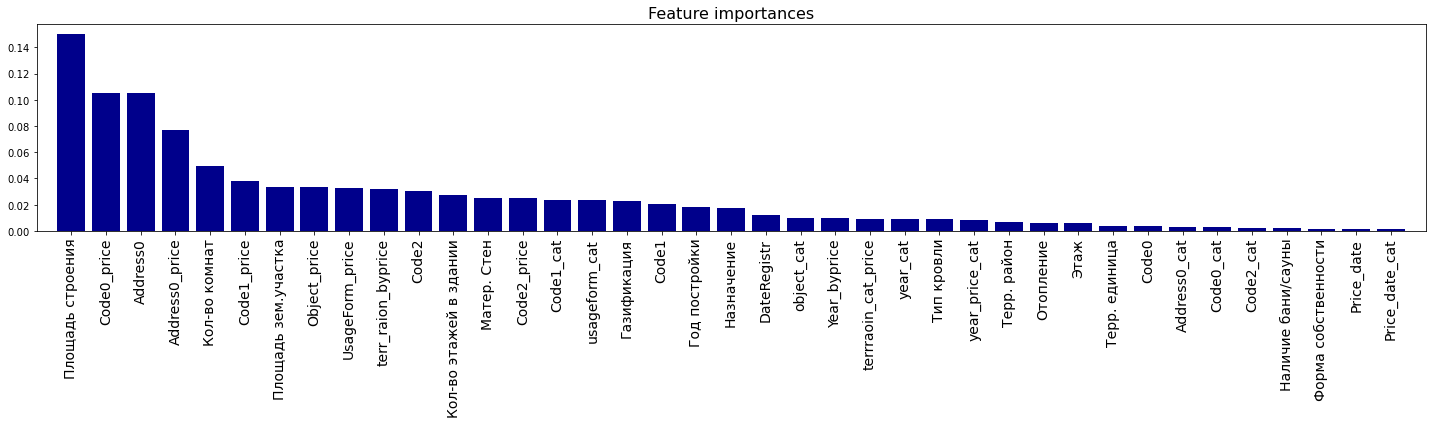

In [149]:
def plot_feature_importances(importances, X):
    indices = np.argsort(importances)[::-1]
    plt.figure(figsize=(20, 6))
    plt.title("Feature importances", fontsize=16)
    plt.bar(range(X.shape[1]), importances[indices] / importances.sum(),
            color="darkblue", align="center")
    plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90, fontsize=14)
    plt.xlim([-1, X.shape[1]])

    plt.tight_layout()
    plt.show()

plot_feature_importances(importances=cbr.feature_importances_, X=X_train)

# Predict on test data

In [ ]:
cbr.fit(train_data, train_y)
y_pred = cbr.predict(test_data)
submission = pd.DataFrame({'Id': test_data.index, 'Predicted': y_pred})
submission.to_csv('submit_cbr_final.csv', index=False)

0:	learn: 0.0115623	total: 44.6ms	remaining: 1m 6s
1:	learn: 0.0227248	total: 82.4ms	remaining: 1m 1s
2:	learn: 0.0338465	total: 128ms	remaining: 1m 4s
3:	learn: 0.0446134	total: 171ms	remaining: 1m 3s
4:	learn: 0.0554190	total: 214ms	remaining: 1m 3s
5:	learn: 0.0658725	total: 254ms	remaining: 1m 3s
6:	learn: 0.0761895	total: 296ms	remaining: 1m 3s
7:	learn: 0.0863112	total: 333ms	remaining: 1m 2s
8:	learn: 0.0961376	total: 382ms	remaining: 1m 3s
9:	learn: 0.1057998	total: 422ms	remaining: 1m 2s
10:	learn: 0.1153876	total: 461ms	remaining: 1m 2s
11:	learn: 0.1247400	total: 497ms	remaining: 1m 1s
12:	learn: 0.1338582	total: 533ms	remaining: 1m
13:	learn: 0.1427889	total: 579ms	remaining: 1m 1s
14:	learn: 0.1515432	total: 618ms	remaining: 1m 1s
15:	learn: 0.1602313	total: 670ms	remaining: 1m 2s
16:	learn: 0.1686911	total: 712ms	remaining: 1m 2s
17:	learn: 0.1769600	total: 750ms	remaining: 1m 1s
18:	learn: 0.1850741	total: 786ms	remaining: 1m 1s
19:	learn: 0.1930737	total: 827ms	remainin

165:	learn: 0.6047054	total: 6.75s	remaining: 54.2s
166:	learn: 0.6053649	total: 6.79s	remaining: 54.2s
167:	learn: 0.6060677	total: 6.82s	remaining: 54.1s
168:	learn: 0.6066992	total: 6.86s	remaining: 54s
169:	learn: 0.6073746	total: 6.9s	remaining: 54s
170:	learn: 0.6079930	total: 6.94s	remaining: 53.9s
171:	learn: 0.6086701	total: 6.98s	remaining: 53.9s
172:	learn: 0.6092849	total: 7.01s	remaining: 53.8s
173:	learn: 0.6099355	total: 7.06s	remaining: 53.8s
174:	learn: 0.6105872	total: 7.1s	remaining: 53.8s
175:	learn: 0.6111748	total: 7.14s	remaining: 53.7s
176:	learn: 0.6117511	total: 7.18s	remaining: 53.7s
177:	learn: 0.6123396	total: 7.22s	remaining: 53.6s
178:	learn: 0.6129459	total: 7.27s	remaining: 53.6s
179:	learn: 0.6135078	total: 7.3s	remaining: 53.6s
180:	learn: 0.6140633	total: 7.34s	remaining: 53.5s
181:	learn: 0.6146191	total: 7.38s	remaining: 53.5s
182:	learn: 0.6151496	total: 7.42s	remaining: 53.4s
183:	learn: 0.6156820	total: 7.46s	remaining: 53.4s
184:	learn: 0.61620

327:	learn: 0.6565607	total: 13.4s	remaining: 47.7s
328:	learn: 0.6567201	total: 13.4s	remaining: 47.7s
329:	learn: 0.6568694	total: 13.4s	remaining: 47.7s
330:	learn: 0.6570318	total: 13.5s	remaining: 47.6s
331:	learn: 0.6571582	total: 13.5s	remaining: 47.5s
332:	learn: 0.6573327	total: 13.5s	remaining: 47.5s
333:	learn: 0.6574611	total: 13.6s	remaining: 47.4s
334:	learn: 0.6575943	total: 13.6s	remaining: 47.4s
335:	learn: 0.6577294	total: 13.7s	remaining: 47.3s
336:	learn: 0.6578522	total: 13.7s	remaining: 47.2s
337:	learn: 0.6579820	total: 13.7s	remaining: 47.2s
338:	learn: 0.6581171	total: 13.8s	remaining: 47.2s
339:	learn: 0.6582578	total: 13.8s	remaining: 47.2s
340:	learn: 0.6583896	total: 13.9s	remaining: 47.1s
341:	learn: 0.6585160	total: 13.9s	remaining: 47.1s
342:	learn: 0.6586248	total: 14s	remaining: 47.1s
343:	learn: 0.6587278	total: 14s	remaining: 47s
344:	learn: 0.6588479	total: 14.1s	remaining: 47.1s
345:	learn: 0.6589804	total: 14.1s	remaining: 47s
346:	learn: 0.659114

489:	learn: 0.6732289	total: 19.9s	remaining: 40.9s
490:	learn: 0.6732851	total: 19.9s	remaining: 40.9s
491:	learn: 0.6733628	total: 19.9s	remaining: 40.8s
492:	learn: 0.6734465	total: 20s	remaining: 40.8s
493:	learn: 0.6735198	total: 20s	remaining: 40.8s
494:	learn: 0.6735639	total: 20.1s	remaining: 40.7s
495:	learn: 0.6736124	total: 20.1s	remaining: 40.7s
496:	learn: 0.6736910	total: 20.2s	remaining: 40.7s
497:	learn: 0.6737618	total: 20.2s	remaining: 40.6s
498:	learn: 0.6738348	total: 20.2s	remaining: 40.6s
499:	learn: 0.6739212	total: 20.3s	remaining: 40.6s
500:	learn: 0.6740068	total: 20.3s	remaining: 40.5s
501:	learn: 0.6740820	total: 20.4s	remaining: 40.5s
502:	learn: 0.6741370	total: 20.4s	remaining: 40.4s
503:	learn: 0.6742242	total: 20.5s	remaining: 40.4s
504:	learn: 0.6743007	total: 20.5s	remaining: 40.4s
505:	learn: 0.6743675	total: 20.5s	remaining: 40.3s
506:	learn: 0.6744162	total: 20.6s	remaining: 40.3s
507:	learn: 0.6744540	total: 20.6s	remaining: 40.3s
508:	learn: 0.67

650:	learn: 0.6829138	total: 26.4s	remaining: 34.4s
651:	learn: 0.6829789	total: 26.4s	remaining: 34.4s
652:	learn: 0.6830272	total: 26.5s	remaining: 34.3s
653:	learn: 0.6831027	total: 26.5s	remaining: 34.3s
654:	learn: 0.6831565	total: 26.6s	remaining: 34.3s
655:	learn: 0.6832293	total: 26.6s	remaining: 34.2s
656:	learn: 0.6832713	total: 26.6s	remaining: 34.2s
657:	learn: 0.6833120	total: 26.7s	remaining: 34.1s
658:	learn: 0.6833769	total: 26.7s	remaining: 34.1s
659:	learn: 0.6834733	total: 26.7s	remaining: 34s
660:	learn: 0.6835596	total: 26.8s	remaining: 34s
661:	learn: 0.6836118	total: 26.8s	remaining: 34s
662:	learn: 0.6837073	total: 26.9s	remaining: 33.9s
663:	learn: 0.6837578	total: 26.9s	remaining: 33.9s
664:	learn: 0.6837841	total: 26.9s	remaining: 33.8s
665:	learn: 0.6838336	total: 27s	remaining: 33.8s
666:	learn: 0.6838598	total: 27s	remaining: 33.7s
667:	learn: 0.6839003	total: 27s	remaining: 33.7s
668:	learn: 0.6839830	total: 27.1s	remaining: 33.6s
669:	learn: 0.6840541	to

809:	learn: 0.6908226	total: 32.6s	remaining: 27.7s
810:	learn: 0.6908716	total: 32.6s	remaining: 27.7s
811:	learn: 0.6909273	total: 32.6s	remaining: 27.7s
812:	learn: 0.6909703	total: 32.7s	remaining: 27.6s
813:	learn: 0.6909982	total: 32.7s	remaining: 27.6s
814:	learn: 0.6910637	total: 32.7s	remaining: 27.5s
815:	learn: 0.6911446	total: 32.8s	remaining: 27.5s
816:	learn: 0.6911968	total: 32.8s	remaining: 27.4s
817:	learn: 0.6912766	total: 32.9s	remaining: 27.4s
818:	learn: 0.6913249	total: 32.9s	remaining: 27.4s
819:	learn: 0.6913811	total: 33s	remaining: 27.3s
820:	learn: 0.6914156	total: 33s	remaining: 27.3s
821:	learn: 0.6914656	total: 33s	remaining: 27.2s
822:	learn: 0.6915055	total: 33.1s	remaining: 27.2s
823:	learn: 0.6915965	total: 33.1s	remaining: 27.2s
824:	learn: 0.6916767	total: 33.2s	remaining: 27.1s
825:	learn: 0.6916994	total: 33.2s	remaining: 27.1s
826:	learn: 0.6917334	total: 33.2s	remaining: 27s
827:	learn: 0.6917807	total: 33.3s	remaining: 27s
828:	learn: 0.6918275	